**Created by Yang Zhou**

**[PLAYGROUND S-3,E-21] 📊EDA + FSS📈**

**22 Aug 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Improve a Fixed Model the Data-Centric Way![EN/CN]</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 22</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Overview</center>

⚪ **An interesting task! Different from the usual prediction tasks, this task requires us to perform good feature engineering to get the best input data set.**

🔴 一个有趣的任务！不同与往常的预测任务，这次的任务需要我们进行良好的特征工程，以得到最佳的输入数据集。

⚪ **This means that we don't need to pay attention to the selection and tuning of the model, which reduces a lot of workload.**

🔴 这意味着我们不需要关注模型的选择和调参，这减少了很多工作量。

⚪ **In the previous task, this [notebook](https://www.kaggle.com/code/alvinleenh/6-basic-feature-selection-techniques) from @DR. ALVINLEENH provided a very detailed idea for feature selection. Thanks for his work.**

🔴 在上一场的任务中，这个[notebook](https://www.kaggle.com/code/alvinleenh/6-basic-feature-selection-techniques)提供了非常详细的思路进行特征选择。感谢他的工作。



# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>

| Version | Description | LB Score |
|---------|-------------|----------|
| Version 1 | EDA and Baseline | |

<a id="0"></a>
# <b> 0. Imports </b>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

<a id="1"></a>
# <b> 1. Load data </b>

In [3]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')
submission.drop('id',axis=1,inplace=True) 
submission.head()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


⚪ **All variables are continuous variables, which means that we can check the correlation coefficient of input variables and target to observe their linear relationship.**

🔴 可以注意到，所有变量均为连续变量，这意味着我们可以检查输入变量与target的相关系数来观察他们的线性关系。

<a id="2"></a>
# <b> 2. Basic EDA </b>

In [4]:
submission.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
target,3500.000000,8.473834,1.885712,1.300000,7.470000,8.280000,9.110000,65.930000
O2_1,3500.000000,8.216993,3.040743,0.000000,7.100000,7.890000,9.100000,46.950000
O2_2,3500.000000,9.291581,6.817822,0.000000,7.300000,8.300000,8.700000,65.950000
O2_3,3500.000000,9.633064,1.439039,4.900000,8.770000,9.500000,9.545000,16.900000
O2_4,3500.000000,8.065733,1.463881,2.300000,6.830000,7.980000,9.265000,21.800000
O2_5,3500.000000,5.671581,2.721399,0.200000,4.550000,5.800000,7.015000,59.400000
O2_6,3500.000000,9.461363,1.140365,0.000000,8.980000,9.430000,10.070000,40.190000
O2_7,3500.000000,6.547433,1.663266,0.000000,5.877500,6.430000,7.150000,15.900000
NH4_1,3500.000000,0.340525,0.284751,0.020000,0.214500,0.247000,0.370000,4.200000
NH4_2,3500.000000,0.397956,0.452237,0.020000,0.200000,0.245000,0.405000,3.600000


In [5]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(submission).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
target,float64,0,0.000000,462,3500,10.460854,1.300000,65.930000,8.473834
O2_1,float64,0,0.000000,329,3500,7.753354,0.000000,46.950000,8.216993
O2_2,float64,0,0.000000,258,3500,4.314217,0.000000,65.950000,9.291581
O2_3,float64,0,0.000000,235,3500,1.254857,4.900000,16.900000,9.633064
O2_4,float64,0,0.000000,241,3500,0.782568,2.300000,21.800000,8.065733
O2_5,float64,0,0.000000,317,3500,3.740421,0.200000,59.400000,5.671581
O2_6,float64,0,0.000000,238,3500,5.246618,0.000000,40.190000,9.461363
O2_7,float64,0,0.000000,303,3500,0.285303,0.000000,15.900000,6.547433
NH4_1,float64,0,0.000000,152,3500,3.237432,0.020000,4.200000,0.340525
NH4_2,float64,0,0.000000,157,3500,3.262280,0.020000,3.600000,0.397956


⚪ **There are no missing values in the data.**

🔴 数据中没有缺失值。

⚪ **The data needs to be normalized.**

🔴 数据可能需要归一化。

⚪ **The skewness of some features is too high, which is also the part that needs to be dealt with.**

🔴 一些数据的偏度过高，这也是需要处理的部分。

In [6]:
target = 'target'
num_var = submission.columns.drop(target)

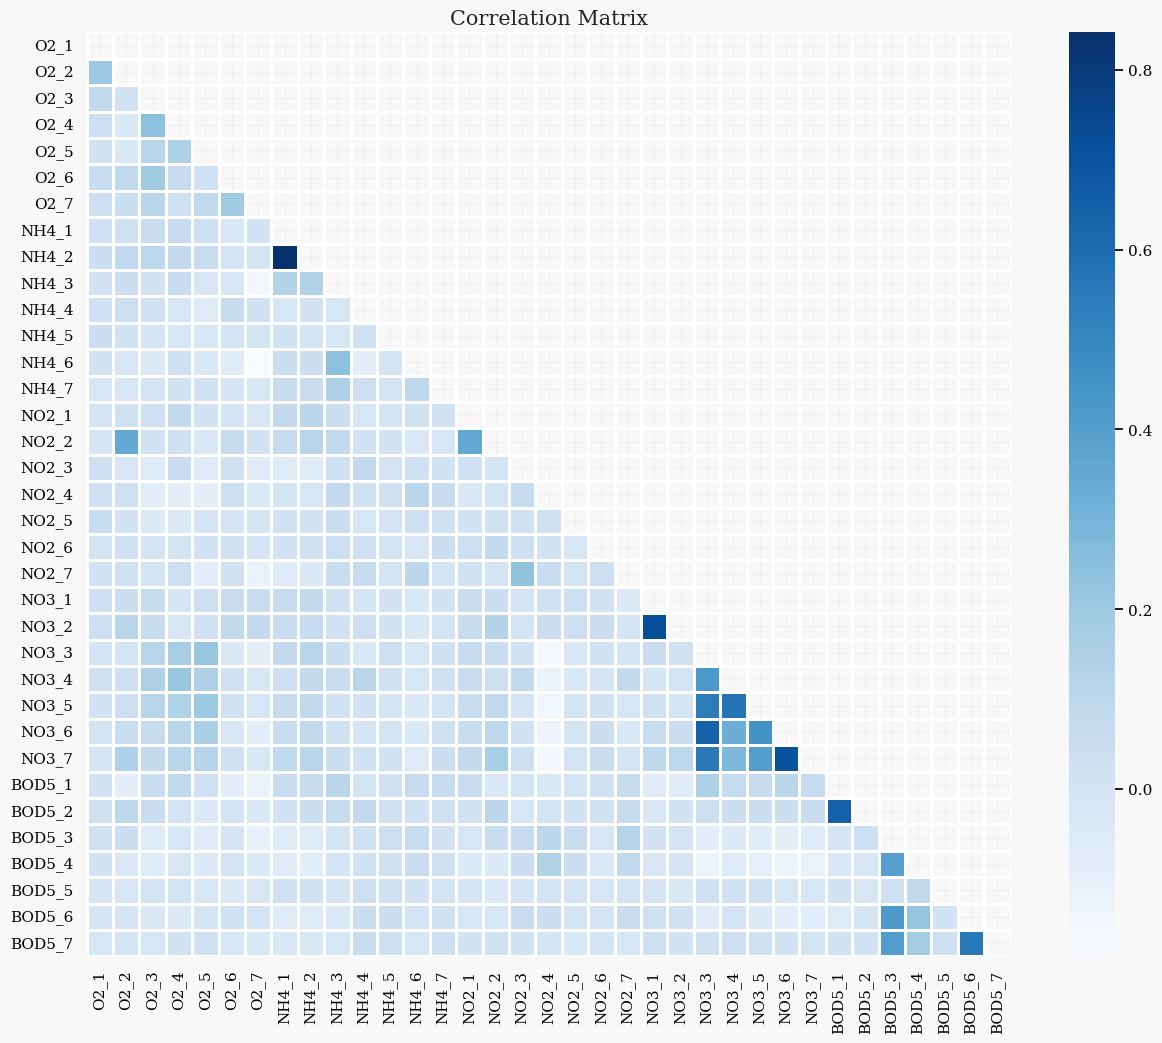

In [7]:
corr_matrix = submission[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

<a id="3"></a>
# <b> 3. Feature Selection</b>

<a id="4"></a>
# <b> 4. Data Preprocessing</b>

In [8]:
def data_preprocessing(df):
    sc = StandardScaler()
    for i in df.columns:
        df[i] = sc.fit_transform(df[i].values.reshape(-1,1))
    return df

submission = data_preprocessing(submission)

<a id="5"></a>
# <b> 5. Submission </b>

In [9]:
submission.to_csv('submission.csv',index=False)

In [10]:
submission.head()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0.061612,-0.235829,-0.042774,-0.061205,0.819355,0.896145,-0.904544,0.362332,-0.563820,-0.437790,-0.647971,1.409650,-0.172476,2.631315,-0.386218,-0.490631,-0.318685,-0.399794,0.016586,-0.181325,-0.119441,1.573404,-0.913697,-0.457739,-0.644936,1.414031,-0.584129,-0.436008,-0.531651,-0.008322,-1.036916,3.047811,1.745500,2.364723,1.188726,3.326378
1,0.332105,1.748509,4.636808,-0.599836,0.819355,0.126210,0.533798,0.362332,2.692119,1.391160,1.362577,0.293754,-0.049312,-0.599924,-0.348082,0.063595,6.293610,-0.399794,0.504445,0.415650,-0.119441,-0.188574,0.237740,1.951476,-0.521345,1.414031,1.761418,2.237113,1.640792,-0.132770,1.419023,-1.072893,-0.298543,-0.567349,-0.475781,-0.970585
2,-0.139932,-1.482413,-0.567943,-0.599836,0.819355,-0.412193,0.533798,0.362332,-1.125794,-0.835868,-0.647971,1.907730,0.193319,-0.278407,-0.348082,-0.208821,-0.318685,-0.182154,0.504445,1.315051,-0.119441,1.573404,-0.144890,-0.324080,-0.090510,-0.993958,-0.641603,0.007799,0.264358,0.058880,0.126423,0.209900,0.041160,-0.292132,-0.148824,-0.474376
3,-0.044464,0.158868,-0.174799,-0.092481,0.774946,-0.173311,-0.694055,0.073701,-0.212586,-0.282981,1.164543,-0.607109,-0.122568,3.258272,2.910771,-0.302758,-0.318685,-0.327248,-0.550693,0.866138,-0.198674,-0.777457,-0.263168,-0.457739,-0.538671,-1.150548,-0.040459,-0.319487,-0.557448,0.738365,-0.035152,-0.375359,0.089689,0.223397,-0.505504,1.742731
4,-0.214185,-0.054926,-0.094117,-1.162792,0.819355,-0.875256,0.533798,0.362332,0.068401,0.081924,-0.647971,-0.610898,-0.172476,-0.599924,-0.348082,0.213894,0.009406,-0.278883,1.497182,-0.181325,0.078640,-0.188574,-0.529293,-0.691644,-0.521345,-1.160210,-1.039259,-0.436008,-0.914915,-0.008322,0.139349,-0.160366,-1.230300,0.150901,-0.148824,-0.089021


<p style="font-family: consolas; font-size: 16px;">⚪ If you like it, please upvote it!</p>